# sparse coding notebook

In [1]:
import numpy as np
import theano 
import theano.tensor as T
import matplotlib.pyplot as plt
import math 
import random 
from scipy.io import loadmat 
from sklearn.feature_extraction.image import PatchExtractor
from collections import OrderedDict
from utils import tile_raster_images as tri
%matplotlib inline

In [2]:
data = loadmat("IMAGES.mat")

In [3]:
ims = np.transpose(data['IMAGES'], (2,0,1))

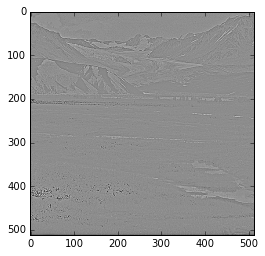

In [4]:
plt.imshow(ims[9], cmap = 'gray') 
plt.show()

In [5]:
shape = (8,8)
dim = np.prod(shape)
patches = PatchExtractor(shape, 64*64).transform(ims)
patches = patches.reshape(-1,dim).astype('float32')

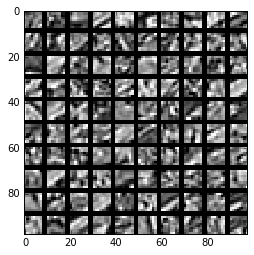

In [6]:
im = tri(patches[:100], shape, (10, 10), (2,2))
plt.imshow(im, cmap='gray', interpolation='nearest')

In [7]:
patches.shape

(40960, 64)

# starting theano

In [8]:
n_batch = 100
n_iter = 150
epochs = 1
nneurons = 1*dim 

In [9]:
x = theano.shared(np.zeros((n_batch,dim)).astype('float32'))
w = theano.shared(np.random.randn(nneurons,dim).astype('float32'))
a = theano.shared(np.zeros((n_batch,nneurons)).astype('float32'))
x_batch = T.matrix() 

In [10]:
# 1 will change 
lam = .1 
eps_a = .01
eps_w = 1

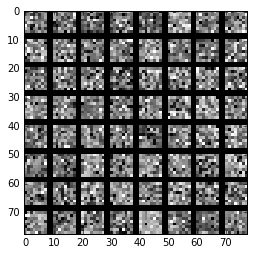

In [11]:
im = tri(w.get_value()[:64], shape, (8, 8), (2,2))
plt.imshow(im, cmap='gray', interpolation='nearest')

In [12]:
costfunction = (.5*(x-T.dot(a,w))**2).sum(axis=1).mean() + lam*abs(a).sum(axis=1).mean() 
grad_a = T.grad(costfunction,a) 
grad_w = T.grad(costfunction,w)

In [13]:
# first function will zero out the a's 
# step_a will begin gradiant descent on a
# step_w will begin gradient descent on w 
updates = OrderedDict()
updates[a] = 0.*a 
zero_a = theano.function([],[],updates = updates)

updates = OrderedDict()
updates[a] = a - eps_a*grad_a 
step_a = theano.function([],[costfunction],updates = updates)
    
updates = OrderedDict()
updates[x] = x_batch
update_x = theano.function([x_batch],[],updates = updates)

updates = OrderedDict()
updates[w] = w - eps_w*grad_w 
step_w = theano.function([],[costfunction],updates = updates) 

# Train the model

In [14]:
for kk in range(epochs):
    for ii in range(int(math.floor(1.*patches.shape[0]/n_batch))):
        zero_a()
        update_x(patches[ii*n_batch : (ii+1)*n_batch])
        for jj in range(n_iter):
            cost = step_a() 
            #print cost
        step_w()
   # plt.figure()
   # im = tri(w.get_value()[:64], shape, (8, 8), (2,2))
   # plt.imshow(im, cmap='gray', interpolation='nearest')

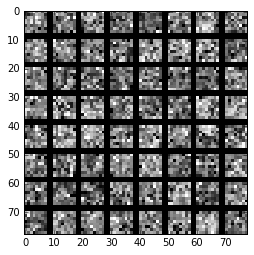

In [25]:
im = tri(w.get_value()[:64], shape, (8, 8), (2,2))
plt.imshow(im, cmap='gray', interpolation='nearest')

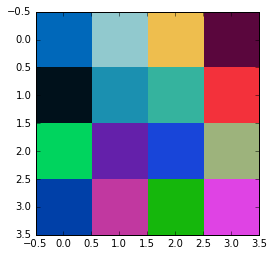

In [125]:
gen_bars(10)

# Bars Data Set:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from datasets import gen_bars

[[[ 1.  0.  1.  0.]
  [ 1.  1.  1.  1.]
  [ 1.  0.  1.  0.]
  [ 1.  0.  1.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 1.  1.  1.  1.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]]

 [[ 0.  1.  0.  1.]
  [ 0.  1.  0.  1.]
  [ 0.  1.  0.  1.]
  [ 0.  1.  0.  1.]]

 [[ 1.  1.  1.  1.]
  [ 0.  1.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 0.  1.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 1.  1.  1.  1.]
  [ 0.  0.  0.  1.]]

 [[ 0.  1.  0.  1.]
  [ 0.  1.  0.  1.]
  [ 0.  1.  0.  1.]
  [ 0.  1.  0.  1.]]

 [[ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]
  [ 1.  0.  0.  0.]
  [ 1.  1.  1.  1.]]

 [[ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 1.  1.  1.  1.]]]


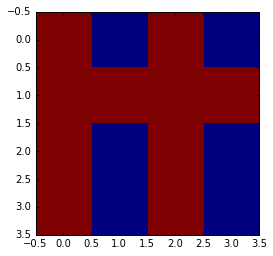

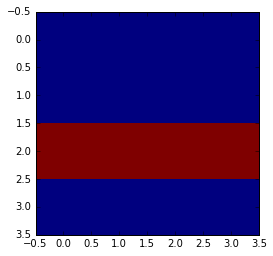

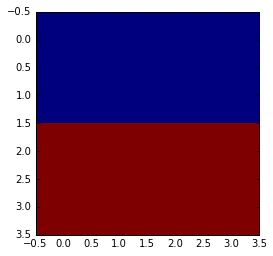

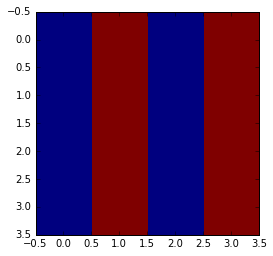

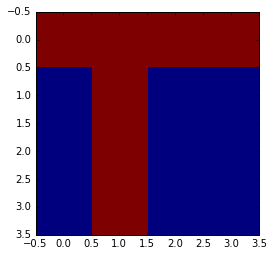

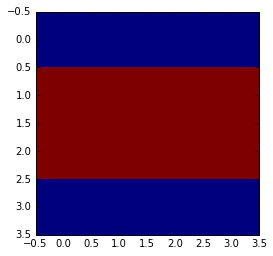

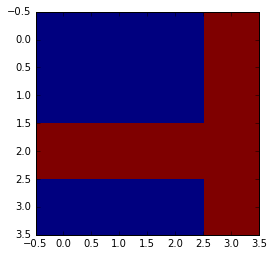

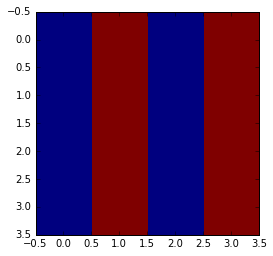

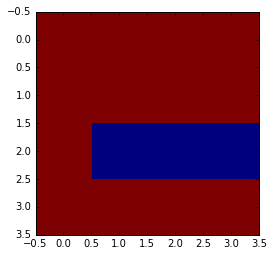

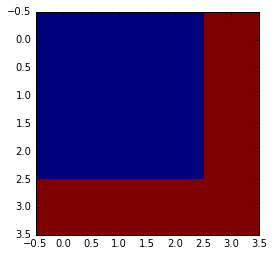

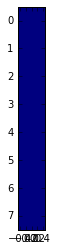

In [5]:

n=10
im,barcolors = gen_bars(n, bw=True)

for j in range(n):
    plt.figure()
    plt.imshow(im[j],interpolation='nearest')
    
plt.figure()
plt.imshow(barcolors[:,np.newaxis],interpolation='nearest')

print im


In [18]:
#!/usr/bin/python

class Point:
   def __init( self, x=0, y=0):
      self.x = x
      self.y = y
   def __del__(self):
      class_name = self.__class__.__name__
      print class_name, "destroyed"

pt1 = Point()
pt2 = pt1
pt3 = pt1
print id(pt1), id(pt2), id(pt3) # prints the ids of the obejcts
del pt1
del pt2
del pt3


140043951830872 140043951830872 140043951830872
Point destroyed


In [11]:
class Cat:
    def __init__(self, name):
        self.name = name
    def info(self):
        print 'I am a cat and I am called', self.name
c = Cat('Kitty')
c.info()

I am a cat and I am called Kitty


In [15]:
#!/usr/bin/python

class Parent:        # define parent class
   parentAttr = 100
   def __init__(self):
      print "Calling parent constructor"

   def parentMethod(self):
      print 'Calling parent method'

   def setAttr(self, attr):
      Parent.parentAttr = attr

   def getAttr(self):
      print "Parent attribute :", Parent.parentAttr

class Child(Parent): # define child class
   def __init__(self):
      print "Calling child constructor"

   def childMethod(self):
      print 'Calling child method'

c = Child()          # instance of child
c.childMethod()      # child calls its method
c.parentMethod()     # calls parent's method
c.setAttr(500)       # again call parent's method
c.getAttr()          # again call parent's method

Calling child constructor
Calling child method
Calling parent method
Parent attribute : 500


In [2]:
class model(object):
    #all similarities between noca,mca,sc
    #open sublime through harpo to access mca, sc scripts
    # inslude dim, n_neurons, eps_a, eps_w
    def __init__(self):
        pass
class noca(model):
    pass
    
class mca(model):
    def __init__(self, dim, n_neurons, eps_a, eps_w):
        self.dim = dim
        self.n_neurons = n_neurons
        self.eps_a = eps_a
        self.eps_w = eps_w
        self.pos_only = pos_only
        self.lam = lam
        self.decay_time = decay_time
    def setup(self):
        x = theano.shared(np.zeros((n_batch,dim)).astype('float32'))
        w = np.random.randn(n_neurons,dim)
        w_norm = np.sqrt(np.sum(w**2, axis=1, keepdims=True))
        w = theano.shared((w/w_norm).astype('float32'))
        a = theano.shared(np.zeros((n_batch,n_neurons)).astype('float32'))
        x_batch = T.matrix() 
        
        x_hat_mca = T.max(a.dimshuffle(0,1,'x')*w.dimshuffle('x',0,1), axis=1)
        recon_mca = (.5*(x- x_hat_mca)**2).sum(axis=1).mean()
        coeff = abs(a).sum(axis=1).mean()
        l0 = T.neq(a,0.).sum(axis=1).mean()
        costfunction_mca = recon_mca+ lam*coeff
        snr_mca = T.mean(x.norm(2,axis=1)**2/(x-x_hat_mca).norm(2,axis=1)**2)
        
        x_hat = x_hat_mca
        costfunction = costfunction_mca
        snr = snr_mca
        
        grad_w = T.grad(costfunction_mca,w)
        grad_recon_a_mca = T.grad(recon_mca,a)
        grad_sparse_a = T.grad(lam*coeff, a)

        updates = OrderedDict()
        updates[eps_w] = np.array(p).astype('float32') * eps_w
        decay_eps_w = theano.function([], [], updates=updates)
        
        updates_mca = OrderedDict()
        
        t = theano.shared(np.array(1.).astype('float32'))
        a_old = theano.shared(np.zeros((n_batch,n_neurons)).astype('float32'))

        a_prime_mca = a - eps_a * grad_recon_a_mca
        abs_a_mca = abs(a_prime_mca) - lam*eps_a
        a_ista_mca = T.sgn(a_prime_mca) * T.nnet.relu(abs_a_mca)

        t1 = 0.5 * (1 + T.sqrt(1. + 4. * t ** 2))
        a_new_mca = a_ista_mca + (t1 - 1.) / t * (a_ista_mca - a_old)
        
        if self.pos_only:
            updates_mca[a] = T.nnet.relu(a_new_mca)
            updates_mca[a_old] = T.nnet.relu(a_ista_mca)
        else:
            updates_mca[a] = a_new_mca
            updates_mca[a_old] = a_ista_mca
        
        updates[a] = 0.*a 
        updates[a_old] = 0. *a_old
        updates[t] = 1.
        
        initialize = theano.function([],[],updates = updates)

        pdates = OrderedDict()
        updates[x] = x_batch
        update_x = theano.function([x_batch],[],updates = updates)

        updates = OrderedDict()
        wp = w - eps_w*grad_w
        wp_norm = T.sqrt(T.sum(w**2, axis=1, keepdims=True))
        updates[w] = wp/wp_norm
        
        step_w = theano.function([],[costfunction],updates = updates)
        
        reconstruct = theano.function([],x_hat)
        original = theano.function([], x)

        cost_array = np.zeros((epochs, n_iter))
        recon_array = np.zeros((epochs, n_iter))
        coeff_array = np.zeros((epochs,n_iter))
        l0_array = np.zeros((epochs,n_iter))
        snr_array = np.zeros((epochs, n_iter))
        hist_array = np.zeros((epochs, n_batch, n_neurons))
        im_array = np.zeros((2, epochs, n_batch, dim))
        w_array = np.zeros((epochs, n_neurons, dim))
    
class sc(model):
    everyone = ['hi', 'bye']
    def __init__(self,dim,n_batch,n_neurons,eps_a,eps_w, decay_time, lam, pos_only= True):
        self.dim = dim
        self.n_batch = n_batch
        self.n_neurons = n_neurons
        self.eps_a = eps_a
        self.eps_w = theano.shared(np.array(eps_w).astype('float32'))
        self.pos_only = pos_only
        self.lam = lam
        self.decay_time = decay_time
    def setup(self):
        n_batch = self.n_batch
        dim = self.dim
        n_neurons = self.n_neurons
        eps_a = self.eps_a
        eps_w = self.eps_w
        pos_only = self.pos_only
        lam = self.lam
        decay_time = self.decay_time
        p = np.exp(np.log(.1)/decay_time)

        x = theano.shared(np.zeros((n_batch,dim)).astype('float32'))
        w = np.random.randn(n_neurons,dim)
        w_norm = np.sqrt(np.sum(w**2, axis=1, keepdims=True))
        w = theano.shared((w/w_norm).astype('float32'))
        a = theano.shared(np.zeros((n_batch,n_neurons)).astype('float32'))
        x_batch = T.matrix() 

        x_hat_sc = T.dot(a,w)
        recon_sc = (.5*(x- x_hat_sc)**2).sum(axis=1).mean()
        coeff = abs(a).sum(axis=1).mean()
        l0 = T.neq(a,0.).sum(axis=1).mean()
        costfunction_sc = recon_sc+ lam*coeff
        snr_sc = T.mean(x.norm(2,axis=1)**2/(x-x_hat_sc).norm(2,axis=1)**2)
        
        x_hat = x_hat_sc
        costfunction = costfunction_sc
        snr = snr_sc
        
        grad_w = T.grad(costfunction_sc,w)
        grad_recon_a_sc = T.grad(recon_sc,a)
        grad_sparse_a = T.grad(lam*coeff, a)

        updates = OrderedDict()
        updates[eps_w] = np.array(p).astype('float32') * eps_w
        self.decay_eps_w = theano.function([], [], updates=updates)

        updates_sc = OrderedDict()
        
        t = theano.shared(np.array(1.).astype('float32'))
        a_old = theano.shared(np.zeros((n_batch,n_neurons)).astype('float32'))

        a_prime_sc = a - eps_a * grad_recon_a_sc
        abs_a_sc = abs(a_prime_sc) - lam*eps_a
        a_ista_sc = T.sgn(a_prime_sc) * T.nnet.relu(abs_a_sc)

        t1 = 0.5 * (1 + T.sqrt(1. + 4. * t ** 2))
        a_new_sc = a_ista_sc + (t1 - 1.) / t * (a_ista_sc - a_old)
        
        if self.pos_only:
            updates_sc[a] = T.nnet.relu(a_new_sc) 
            updates_sc[a_old] = T.nnet.relu(a_ista_sc)
        else:
            updates_sc[a] = a_new_sc
            updates_sc[a_old] = a_ista_sc
            
        updates[a] = 0.*a 
        updates[a_old] = 0. *a_old
        updates[t] = 1.
        
        self.initialize = theano.function([],[],updates = updates)
        
        updates = OrderedDict()
        updates[x] = x_batch
        self.update_x = theano.function([x_batch],[],updates = updates)

        updates = OrderedDict()
        wp = w - eps_w*grad_w
        wp_norm = T.sqrt(T.sum(w**2, axis=1, keepdims=True))
        updates[w] = wp/wp_norm
        
        self.step_w = theano.function([],[costfunction],updates = updates)
        
        self.reconstruct = theano.function([],x_hat)
        self.original = theano.function([], x)
        
    def train(self,patches):
        #go through and check all self.batch is changed for batch, etc.
        #start trying the model by importing the image data
        
        n_iter = self.n_iter
        n_batch = self.n_batch
        n_neurons = self.n_neurons
        dim = self.dim

        cost_array = np.zeros((epochs, n_iter))
        recon_array = np.zeros((epochs, n_iter))
        coeff_array = np.zeros((epochs,n_iter))
        l0_array = np.zeros((epochs,n_iter))
        snr_array = np.zeros((epochs, n_iter))
        hist_array = np.zeros((epochs, n_batch, n_neurons))
        im_array = np.zeros((2, epochs, n_batch, dim))
        w_array = np.zeros((epochs, n_neurons, dim))
        
        
        for kk in range(epochs):
            print kk
            for ii in range(int(math.floor(1.*patches.shape[0]/n_batch))):
                initialize()
                update_x(patches[ii*n_batch : (ii+1)*n_batch])
                for jj in range(n_iter):
                    if sparse_coding:
                        cost, recon, coeff, l0, snr = step_a_sc()
                    else:
                        if jj < n_iter/10:
                            cost, recon, coeff, l0, snr = step_a_sc()
                        else:
                            cost, recon, coeff, l0, snr = step_a_mca()
                    if ii == 0:
                        cost_array[kk, jj] = cost
                        recon_array[kk, jj] = recon
                        coeff_array[kk, jj] = coeff
                        l0_array[kk, jj] = l0
                        snr_array[kk, jj] = snr
                if kk > decay_init:
                     decay_eps_w()
                if ii == 0:
                    hist_array[kk] = a.get_value()
                    im_array[0, kk] = np.array(original())
                    im_array[1, kk] = reconstruct()
                    w_array[kk] = w.get_value() 
                step_w()
                
        model = dict() 
        model['sparse_coding']  = sparse_coding
        model['w'] = w.get_value()
        model['cost_array'] = cost_array
        model['recon_array'] = recon_array
        model['l0_array'] = l0_array
        model['snr_array'] = snr_array
        model['hist_array'] = hist_array
        model['coeff_array'] = coeff_array
        model['im_array'] = im_array
        model['w_array'] = w_array
        return model 

        
    def print_me(self):
        print self.dim
        print self.n_neurons
        print self.eps_a
        print self.eps_w
        print self.everyone

In [3]:
my_model = sc(10, 20, 5, .1, 50, .006, .1)

In [4]:
my_model.print_me()
my_model.setup()

10
5
0.1
<TensorType(float32, scalar)>
['hi', 'bye']


TypeError: ('An update must have the same type as the original shared variable (shared_var=<TensorType(float32, matrix)>, shared_var.type=TensorType(float32, matrix), update_val=<TensorType(float64, matrix)>, update_val.type=TensorType(float64, matrix)).', 'If the difference is related to the broadcast pattern, you can call the tensor.unbroadcast(var, axis_to_unbroadcast[, ...]) function to remove broadcastable dimensions.')

In [25]:
my_model.everyone[0] = 'heyo'

In [40]:
my_model2 = sc(20, 40, .1, .1)

In [44]:
my_model2.print_me()

20
40
0.1
0.1
['heyo', 'bye']


In [23]:
sc.everyone

'hi'

AttributeError: type object 'sc' has no attribute 'self'